In [1]:
from TravelAndMutate.randominterface import NumpyRandomGenerator
from TravelAndMutate.system import System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from scipy.optimize import root_scalar

In [3]:
seed = np.prod([ord(c) for c in "TravelAndMutate"]).astype("uint32")
rng = NumpyRandomGenerator(seed)

In [4]:
def kernel(rng, tmax, params, commuting_mat):
    sys = System(rng.cpprng, 1, "mix", commuting_mat, params.to_records(index=False))
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params.shape[0])]

In [5]:
def Rinf_equation(Rinf, R0, s0):
    return 1 - Rinf - s0 * np.exp(-Rinf*R0)

In [6]:
Npatch = 4

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


,N,beta,epsilon,mu,I0,R0
Patch,,,,,,
0,1000000,0.06,0.001,0.03,1000000,2.0
1,1000000,0.06,0.001,0.03,1000000,2.0
2,1000000,0.06,0.001,0.03,1000000,2.0
3,1000000,0.06,0.001,0.03,1000000,2.0


Duration per replica: 0.03 sec


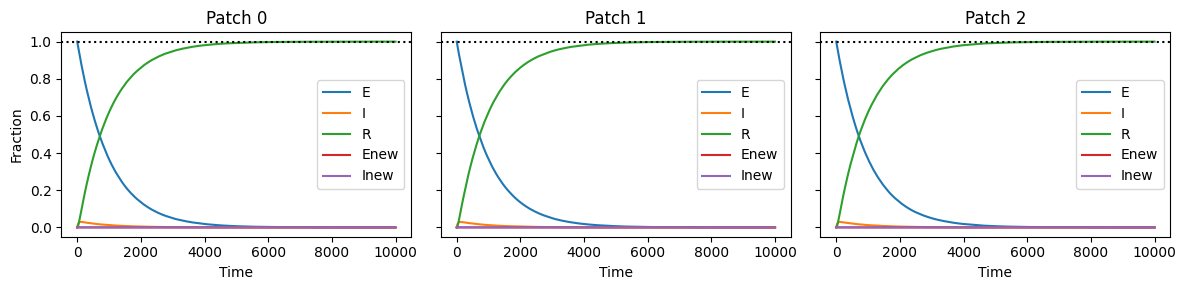

In [21]:
start = time()

commuting = np.where(np.eye(Npatch).astype(bool), 1, 0)# rng.rng.random(size=(Npatch,Npatch))/Npatch**2)
display(pd.DataFrame(commuting))

tmax = 10000

params = pd.DataFrame()
params["N"] = np.full(Npatch, 1e6, dtype="u4")
params["beta"] = np.full(Npatch, 0.06)# + rng.rng.normal(scale=0.01, size=Npatch)
params["epsilon"] = np.full(Npatch, 0.001)# + rng.rng.normal(scale=0.005, size=Npatch)
params["mu"] = np.full(Npatch, 0.03)# + rng.rng.normal(scale=0.005, size=Npatch)
#params["I0"] = np.full(Npatch, 10)
params["I0"] = params["N"]
params.index.name = "Patch"
display(params)

reps = 5
for i in range(reps):
    result = kernel(rng, tmax, params, commuting)

end = time()
print(f"Duration per replica: {np.round((end-start)/5, 2)} sec")

params["R0"] = (params["beta"] / params["mu"]) @ commuting

fig, axs = plt.subplots(1,3,figsize=(12,3),sharey=True)
for i in range(min(Npatch,len(axs))):
    result[i].drop("S", axis=1).plot(ax=axs[i])
    axs[i].set_title(f"Patch {i}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Fraction")
    Rinf = root_scalar(Rinf_equation, args=(params["R0"][i],1-params["I0"][i]/params["N"][i]), x0=params["R0"][i]).root
    #axs[i].axhline(Rinf, color="k", linestyle=":")
    axs[i].axhline(params["I0"][i]/params["N"][i], color="k", linestyle=":")
fig.tight_layout()

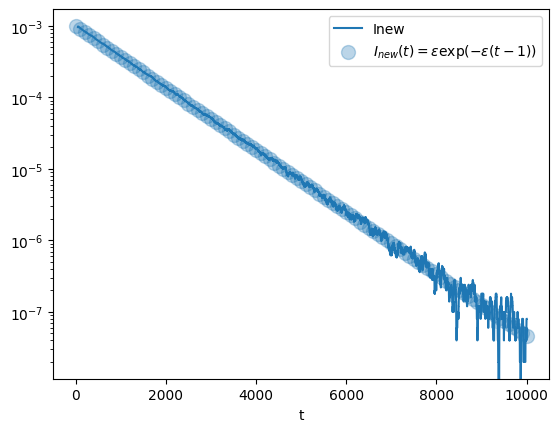

In [34]:
result[2]["Inew"].rolling(50).mean().plot()
xs = np.linspace(1,tmax,101)
epsilon = params["epsilon"][0]
plt.scatter(xs, epsilon*np.exp(-(xs-1)*epsilon), marker="o", s=100, alpha=0.3, label=r"$I_{new}(t) = \varepsilon \exp(-\varepsilon(t-1))$")
plt.legend()
plt.yscale("log")

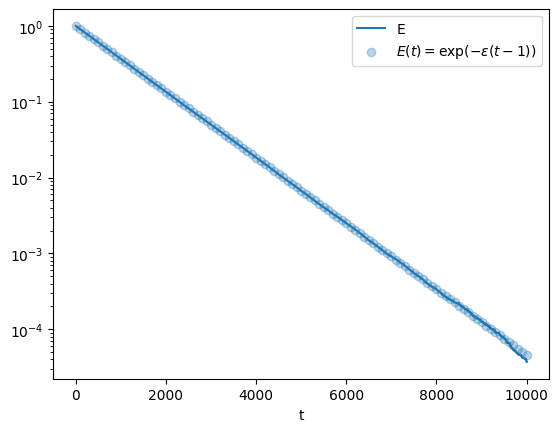

In [35]:
result[2]["E"].plot()
xs = np.linspace(1,tmax,101)
epsilon = params["epsilon"][0]
corr = (1+0.06)
plt.scatter(xs, np.exp(-(xs-1)*epsilon), marker="o", alpha=0.3, label=r"$E(t) = \exp(-\varepsilon(t-1))$")
plt.legend()
plt.yscale("log")